In [23]:
import pandas as pd
import os
import torch
import json
from torchsummary import summary
from src.anti_spoof_predict import AntiSpoofPredict
import torch.nn as nn
from tqdm import tqdm
import time 


In [13]:
df = pd.read_csv("dataset.csv")
df.rename(columns={'Real': 'Prediction', '40':'SpoofType', '41':'Illumination', '42':'Environment', '43':'Spoof'}, inplace=True)
# the prediction by silent face takes values 0-2. Gotta convert it.
df['Prediction'] = df['Prediction'].replace({0.0: 1, 1.0: 0, 2.0: 1})
df['Prediction'] = df['Prediction'].astype(int)
df.head(10)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,36,37,38,39,SpoofType,Illumination,Environment,Spoof,Prediction,Prediction Score
0,Data/test/6964/spoof/494405.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,2,2,1,0,0.997231
1,Data/test/6407/spoof/494411.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,2,1,0,0.604510
2,Data/test/6153/spoof/494412.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,1,1,1,0.378704
3,Data/test/6411/live/494418.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.997799
4,Data/test/6336/spoof/494419.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,1,1,0,0.954367
5,Data/test/5162/live/494421.png,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0.654609
6,Data/test/6074/live/494424.png,0,0,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0.989915
7,Data/test/7483/live/494428.png,0,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0.989566
8,Data/test/9735/spoof/494436.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,1,1,1,1,0.998543
9,Data/test/4943/live/494437.png,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0.999986


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        26000 non-null  object 
 1   0                 26000 non-null  int64  
 2   1                 26000 non-null  int64  
 3   2                 26000 non-null  int64  
 4   3                 26000 non-null  int64  
 5   4                 26000 non-null  int64  
 6   5                 26000 non-null  int64  
 7   6                 26000 non-null  int64  
 8   7                 26000 non-null  int64  
 9   8                 26000 non-null  int64  
 10  9                 26000 non-null  int64  
 11  10                26000 non-null  int64  
 12  11                26000 non-null  int64  
 13  12                26000 non-null  int64  
 14  13                26000 non-null  int64  
 15  14                26000 non-null  int64  
 16  15                26000 non-null  int64 

In [15]:
model_path = "resources/anti_spoof_models/2.7_80x80_MiniFASNetV2.pth"
device_id = 0

model = AntiSpoofPredict(device_id)
model._load_model(model_path)

summary(model.model, input_size=(3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 40]             864
       BatchNorm2d-2           [-1, 32, 40, 40]              64
             PReLU-3           [-1, 32, 40, 40]              32
        Conv_block-4           [-1, 32, 40, 40]               0
            Conv2d-5           [-1, 32, 40, 40]             288
       BatchNorm2d-6           [-1, 32, 40, 40]              64
             PReLU-7           [-1, 32, 40, 40]              32
        Conv_block-8           [-1, 32, 40, 40]               0
            Conv2d-9          [-1, 103, 40, 40]           3,296
      BatchNorm2d-10          [-1, 103, 40, 40]             206
            PReLU-11          [-1, 103, 40, 40]             103
       Conv_block-12          [-1, 103, 40, 40]               0
           Conv2d-13          [-1, 103, 20, 20]             927
      BatchNorm2d-14          [-1, 103,

In [16]:
class CustomModel(nn.Module):
    def __init__(self, original_model):
        super(CustomModel, self).__init__()
        # all the layers except the final linear layer:
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x
    
def copy_weights(original_model, custom_model):
    original_state_dict = original_model.state_dict()
    custom_state_dict = custom_model.state_dict()

    for name, param in original_state_dict.items():
        if name in custom_state_dict:
            custom_state_dict[name].copy_(param)

# custom_model = CustomModel(model.model).to(model.device)


In [17]:
image_cropper = CropImage()

def dropout_embeddings(image_path):
    custom_model = CustomModel(model.model).to(model.device)
    copy_weights(model.model, custom_model)

    test_transform = trans.Compose([
        trans.ToTensor(),
    ])

    image = cv2.imread(image_path)
    image_bbox = model.get_bbox(image)
    param = {
        "org_img": image,
        "bbox": image_bbox,
        "scale": 2.7,
        "out_w": 80,
        "out_h": 80,
        "crop": True,
    }
    image = image_cropper.crop(**param)
    image = test_transform(image).unsqueeze(0).to(model.device)

    with torch.no_grad():
        custom_model.eval()
        embeddings = custom_model(image)

    return embeddings

embeddings = dropout_embeddings(image_path="/Users/kassymmukhanbetiyar/Development/Verigram/CelebA/archive/CelebA_Spoof_/CelebA_Spoof/Data/test/3613/spoof/511091.png")
print(embeddings.shape)
print(embeddings)

torch.Size([1, 128])
tensor([[ 1.2069e-01,  1.5503e-01,  8.7111e-02, -7.0137e-02,  1.5489e-01,
          3.2077e-02,  7.0152e-01,  9.8637e-02, -8.2030e-01, -1.4541e-01,
         -7.5033e-01, -4.6642e-02, -1.3364e-01,  7.1169e-02, -1.7844e-01,
          1.5394e-01,  7.7757e-02, -2.7461e-01, -6.5875e-01, -9.0550e-02,
          5.5744e-02, -1.2869e-01, -1.5484e-01,  9.4751e-02,  8.6219e-01,
         -1.3932e-01, -1.0559e-01, -1.6169e-01,  4.0786e-03, -5.7072e-01,
          1.5701e-01,  5.7515e-02, -8.6205e-01, -2.4113e-01, -7.2018e-01,
         -9.5627e-02, -1.7645e-01, -8.9955e-01,  1.3869e-01, -6.9634e-01,
          1.0365e-01, -3.2775e-01,  7.2050e-01, -1.8214e-01, -1.3797e-01,
          1.5122e-01, -1.0448e-01, -6.4250e-01, -8.5432e-01, -2.3782e-01,
         -9.7740e-02,  1.0299e-01,  7.2600e-01,  1.5211e-01,  8.8101e-02,
          1.8405e-01, -1.5377e-02, -1.7951e-02, -1.6631e-01, -1.2070e-01,
         -8.4253e-01, -9.4419e-02, -9.2114e-02,  7.4707e-01, -1.7906e-01,
          1.6074e

In [18]:
test_label = pd.read_json('test_label.json')
print(test_label.shape)

(44, 25758)


## In the following snippet you can stop prematurely to get embeddings for a small number of images.

In [25]:
def fill_dropout_csv(model_path="resources/anti_spoof_models/2.7_80x80_MiniFASNetV2.pth", checkpoint_path="dropout_embeddings.csv"):
    # Get the number of processed images
    processed_count = 0
    image_dir = "/Users/kassymmukhanbetiyar/Development/Verigram/CelebA/archive/CelebA_Spoof_/CelebA_Spoof/"
    if os.path.isfile(checkpoint_path):
        processed_count = sum(1 for _ in open(checkpoint_path)) - 1  # Subtract 1 to exclude the header row

    # Get the remaining image paths to process
    with open('test_label.json', 'r') as file:
        test_labels = json.load(file)

    remaining_image_names = list(test_labels.keys())[processed_count:]

    # Create a new DataFrame for the newly processed images
    new_embeddings_df = pd.DataFrame(columns=range(1, 129))

    total_iterations = len(remaining_image_names)
    progress_bar = tqdm(total=total_iterations, ncols=80, dynamic_ncols=True, smoothing=0.5)
    # Initialize start time
    start_time = time.time()

    # Iterate over the remaining image paths and fill in the embeddings
    for i, image_name in enumerate(remaining_image_names, start=processed_count + 1):
        image_path = image_dir + image_name
        embeddings = dropout_embeddings(image_path)

        # Add the embeddings to the new DataFrame
        new_embeddings_df.loc[image_name] = embeddings.reshape(1, -1).tolist()[0]  # Reshape to (1, 128)

        # Append the new embeddings to the existing DataFrame and CSV file every 250 iterations
        if i % 250 == 0 or i == len(remaining_image_names):
            new_embeddings_df.to_csv(checkpoint_path, mode='a', header=(i == 250))
            new_embeddings_df = pd.DataFrame(columns=range(1, 129))
            # Update progress bar
            progress_bar.update(250 if i % 250 == 0 else i % 250)
            progress_bar.set_postfix({'Remaining': f'{total_iterations - i}', 'Elapsed': f'{time.time() - start_time:.2f}s'})
    return checkpoint_path

fill_dropout_csv()

100%|██████████| 21758/21758 [14:41<00:00, 24.69it/s, Remaining=-3992, Elapsed=880.91s]


'dropout_embeddings.csv'

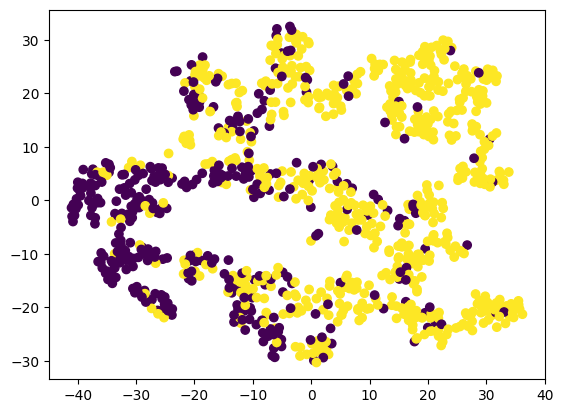

In [33]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load embeddings from CSV file
embeddings = pd.read_csv('dropout_embeddings.csv', index_col=0)
embeddings = embeddings[:1000] 

# Create t-SNE object
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto")

# Fit t-SNE model to embeddings
tsne_embeddings = tsne.fit_transform(embeddings)

# Visualize t-SNE embeddings
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c = df['Spoof'][:1000], cmap = 'viridis')
plt.show()

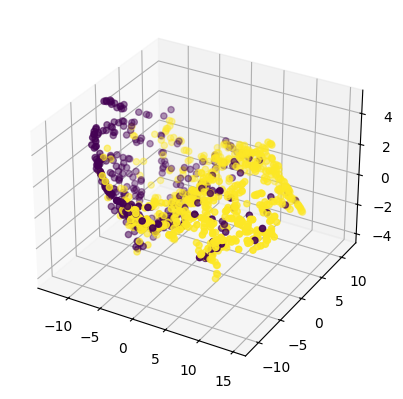

In [31]:
# Create t-SNE object with 3 components
tsne3 = TSNE(n_components=3, perplexity=30, learning_rate="auto")

# Fit t-SNE model to embeddings
tsne3_embeddings = tsne3.fit_transform(embeddings)

# Visualize t-SNE embeddings in 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3_embeddings[:, 0], tsne3_embeddings[:, 1], tsne3_embeddings[:, 2], c = df['Spoof'][:1000], cmap = 'viridis')
plt.show()

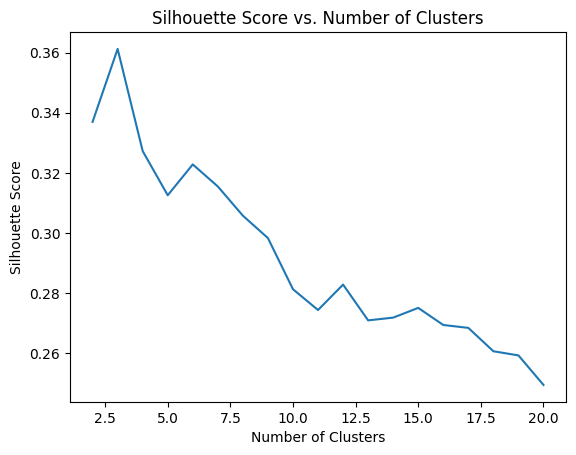

In [35]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Define the range of number of clusters to try
min_clusters = 2
max_clusters = 20
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

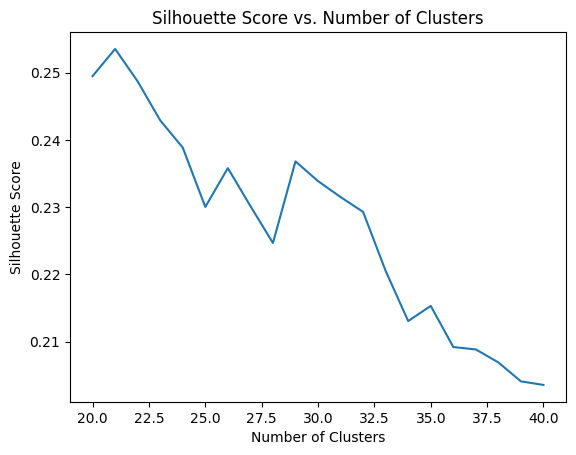

In [36]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Define the range of number of clusters to try
min_clusters = 20
max_clusters = 40
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

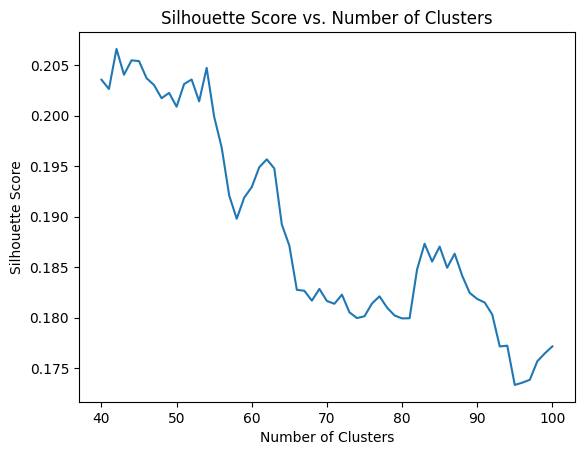

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Define the range of number of clusters to try
min_clusters = 40
max_clusters = 100
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

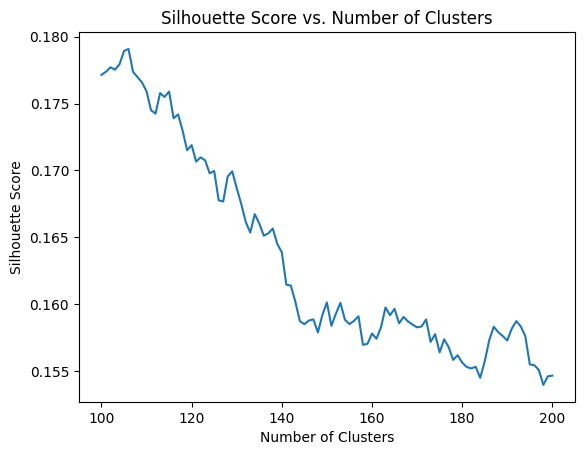

In [38]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Define the range of number of clusters to try
min_clusters = 100
max_clusters = 200
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [ ]:
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)


n_clusters=np.arange(2, 20)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(embeddings, test_size=0.5)
        
        gmm_train=GMM(n, n_init=2).fit(train) 
        gmm_test=GMM(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()